In [4]:
# Importing all the dependencies

import numpy as np
from matplotlib import pyplot as plt
import cv2
import ipdb
import scipy
import math
from itertools import combinations

In [38]:
def getCentroid(points):
    xSum = sum([i[0] for i in points])
    ySum = sum([i[1] for i in points])
    centroid = (xSum/len(points), ySum/len(points) )

    return centroid

In [39]:
def recenter(points):
    centroid = getCentroid(points)
    recentered = np.empty((len(points), len(points[0])), dtype = np.float32)
    for i, point in enumerate(points):
        recentered[i][0] = (point[0]-centroid[0])
        recentered[i][1] = (point[1]-centroid[1])
    
    return np.array([centroid]), recentered

In [113]:
def findRotationTranslation(pointsA, pointsB):
    centroidA, recenteredA = recenter(pointsA)
    centroidB, recenteredB = recenter(pointsB)
    translatinMat = (28.83459, 97.6666)
    print("shape of centroid A", centroidA.shape)
    dim = len(pointsA[0])
    H = []
    for i in range(dim):

        recenteredRowA = np.array([recenteredA[i]])
        recenteredRowB = np.array([recenteredB[i]])
        if i == 0:
            
            H = np.matmul(recenteredRowA.T, recenteredRowB)
        H = np.add(H, np.matmul(recenteredRowA.T, recenteredRowB))
    S, U, Vt = cv2.SVDecomp(H)
    rotMat = np.matmul(Vt.T, U.T)
    rot = round(math.degrees(np.arccos(rotMat[0, 0])))
    backTransf = np.matmul(np.negative(rotMat),centroidB.T)
#     print("backTrans", backTransf)
#     print("B center", centroidB.T)
#     print("A center", centroidA.T)
    translationMat = np.subtract(centroidA.T, backTransf) 

    return rot, translatinMat

In [8]:
def getMatchedPairs(Corners1, Corners2, Angles1, Angles2):
    matchedPairs = list()
    for i in range(len(Angles1)):
        for j in range(len(Angles2)):
            if(abs(Angles2[j]-Angles1[i]) < 1):
                matchedPairs.append((Corners1[i],Corners2[j]))
    return matchedPairs

In [10]:
def getAngle(b, tup):
    a, c = tup
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
    ba = a - b
    bc = c-b
    
    cosin_angl = np.dot(ba,bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angl = np.arccos(cosin_angl)
    return np.degrees(angl)

In [11]:
def getAngles(Points):

    size = len(Points)
    
    maxAngle = list()
    for i, point in enumerate(Points):
        #calculate angles from i to each of the other 2 points
        angles = list()
        pointsList = list(combinations((Points[:i]+Points[i+1:]),2))
        
        for j, pair in enumerate(pointsList):
            angles.append(getAngle(point,pair))
        
        maxAngle.append(max(angles))
    return maxAngle

In [12]:
def getDistanceSum(Points):
    size = len(Points)
    distArr = np.empty((size,size), dtype= np.float32)
    distSum = np.zeros(size, dtype = np.float32)
    for i in range(size):
        for j in range(i,size):
            if i==j:
                distArr[i,j]=0
            else:
                distArr[i, j] = np.sqrt(((Points[i][0]-Points[j][0])**2)+((Points[i][1]-Points[j][1])**2))
                distArr[j, i] = distArr[i, j]
        distSum[i] = np.sum(distArr[i])
    
    
    return distSum                                         

In [13]:
######## Problem 4 2D Transformations ##########

In [14]:
def binaryHistogram(image, points):
    hist = list()
    for i, coord in enumerate(points):
        imgWindow = image[coord[1]-2 : coord[1]+2, coord[0]-2:coord[0]+2]
        hist.append(np.sum(imgWindow))
    return hist

In [84]:
# function for performing corner detection
def detectHarris(Img):
    row, col = Img.shape
    iX = cv2.Sobel(Img,cv2.CV_64F,1,0,ksize = 3)
    iXNorm = iX - np.mean(iX)
    iY = cv2.Sobel(Img,cv2.CV_64F,0,1,ksize = 3)
    iYNorm = iY - np.mean(iY)
    iX_2 = iXNorm*iXNorm
    iY_2 = iYNorm*iYNorm
    iXY = iXNorm*iYNorm

    iX_2Norm = cv2.GaussianBlur(iX_2, (3,3), 2)
    iY_2Norm = cv2.GaussianBlur(iY_2, (3,3), 2)
    iXYNorm = cv2.GaussianBlur(iXY, (3,3), 2)
    R = np.zeros((row, col))
    maxCorner = 0
    cornerIndices = list()
    for i in range(row):
        for j in range(col):
            M = np.array([[iX_2Norm[i,j], iXYNorm[i,j]],[iXYNorm[i,j], iY_2Norm[i,j]]], dtype = np.float64)
            R[i, j] = np.linalg.det(M) - 0.04 * np.power(np.trace(M),2)
            if (R[i,j]>maxCorner):
                maxCorner = R[i, j]
    for k in range(1, row-1):
        for l in range(1, col-1):            
            if(R[k,l]> 0.3*maxCorner and R[k,l]>R[k-1,l-1] and R[k,l]> R[k-1, l+1] and R[k,l]>R[k+1, l-1]) and R[k,l]>R[k+1, l+1] and R[k,l]>R[k, l-1] and R[k,l]>R[k-1, l] and R[k,l]>R[k, l+1] and R[k,l]>=R[k+1, l] :  
                cornerIndices.append([l,k])
    return cornerIndices


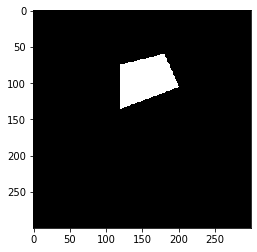

(155.0, 93.75)

In [85]:
######## Section 4.1 ##########
img = np.zeros((300,300), np.uint8)
polyPoints = np.array([[180, 60], [120,75], [120, 135], [200, 105]], dtype = np.int32)

# notice the points' center is its centroid
centerForRot = getCentroid(polyPoints)
# centerForRot = (centerForRot[1], centerForRot[0])
originalImg = cv2.fillPoly(img, [polyPoints], 1)

plt.imshow(originalImg, 'gray')
plt.show()
centerForRot
#center = img.shape

Rotation and Translation is not commutative. Hence to get a rotated quadrilateral at a different location, we must first perform rotation of the square around the center and then translate it

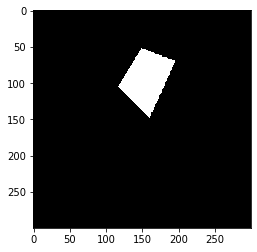

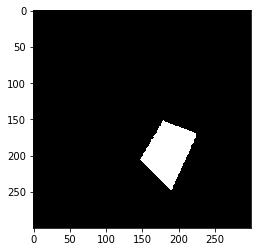

In [86]:
rotationMat = cv2.getRotationMatrix2D(centerForRot, 45, 1)
rotatedImg = cv2.warpAffine(originalImg, rotationMat, originalImg.shape)
plt.imshow(rotatedImg, 'gray')
plt.show()
translationMatrix = np.float32([[1,0,30],[0,1,100]])
translatedImg = cv2.warpAffine(rotatedImg, translationMatrix, img.shape)
plt.imshow(translatedImg, 'gray')

In [87]:
cornersTransformed = detectHarris(translatedImg)
cornersOriginal = detectHarris(originalImg)
print('original image corners ',cornersOriginal)
print('Transformed image corners ',cornersTransformed)
# pointsList = list(combinations(cornersOriginal[:1]+cornersOriginal[1+1:],2))
# print(pointsList)

original image corners  [[180, 60], [120, 75], [200, 105], [120, 135]]
Transformed image corners  [[179, 153], [224, 170], [147, 205], [189, 247]]


In [88]:
anglesOriginal = getAngles(cornersOriginal)
print(anglesOriginal)
anglesTransformed = getAngles(cornersTransformed)
print(anglesTransformed)
matches = getMatchedPairs(cornersOriginal, cornersTransformed, anglesOriginal, anglesTransformed)
#storing matches in respective pairs as list with same indexes
matchedPoints1 = [i[0] for i in matches]
matchedPoints2 = [i[1] for i in matches]
print(matchedPoints1)
print(matchedPoints2)

[99.92624550665171, 104.03624346792648, 86.59355624500529, 69.44395478041653]
[100.91205151218563, 86.25149595364675, 103.3924977537511, 69.44395478041653]
[[180, 60], [120, 75], [200, 105], [120, 135]]
[[179, 153], [147, 205], [224, 170], [189, 247]]


In [114]:
rotAngle, transMat = findRotationTranslation(matchedPoints1,matchedPoints2)

print("The rotation angle dervicd from Least Square optimization is ", rotAngle)
print("translation retained is", transMat)

shape of centroid A (1, 2)
The rotation angle dervicd from Least Square optimization is  45
translation retained is (28.83459, 97.6666)
